## This notebook uses regression.ipynb as a base and predicts with XGBoost algorithm only the IA supernovae cases and filter the objects with few interpolation points (on GP preprocess step) in order to obtain a better RMSE score.
The objective of this notebook was to understand the possible errors on regression methods and improve them.

In [1]:
%load_ext autoreload
%autoreload 2
import os 
import sys
import time
import h2o

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from h2o.automl import H2OAutoML

In [2]:
module_path = os.path.abspath(os.path.join('..','..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.modeling.functions_autoML import gen_predictions
from src.modeling.evaluation import get_metrics_from_batchs

In [3]:
df = pd.read_pickle("../../data/structured/df.pkl")
#IA Filter
df = df.loc[df.type_bool == True]

In [4]:
h2o.init(ip="localhost", port=54323)


Checking whether there is an H2O instance running at http://localhost:54323 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.16" 2022-07-19; OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu120.04); OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu120.04, mixed mode, sharing)
  Starting server from /home/fm/Projects/photometric-redshift-prediction/.photometric_redshift_prediction/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpm3y5j08j
  JVM stdout: /tmp/tmpm3y5j08j/h2o_fm_started_from_python.out
  JVM stderr: /tmp/tmpm3y5j08j/h2o_fm_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.6
H2O_cluster_version_age:,1 year and 14 days !!!
H2O_cluster_name:,H2O_from_python_fm_wxtrm1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.922 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [5]:
best_model = h2o.import_mojo('../../models/models/mojo_50_ensemble/StackedEnsemble_AllModels_AutoML_20201223_115349.zip')

generic Model Build progress: |███████████████████████████████████████████| 100%
Model Details
H2OGenericEstimator :  Import MOJO Model
Model Key:  Generic_model_python_1662199252358_1

No model summary for this model

ModelMetricsRegressionGeneric: generic
** Reported on train data. **

MSE: 0.0029843621318644473
RMSE: 0.0546293156818246
MAE: 0.04095889497837518
RMSLE: 0.030993632001274172
Mean Residual Deviance: 0.0029843621318644473

ModelMetricsRegressionGeneric: generic
** Reported on cross-validation data. **

MSE: 0.007612769296751577
RMSE: 0.0872511850736228
MAE: 0.06616340247814928
RMSLE: 0.05020608420962501
Mean Residual Deviance: 0.007612769296751577



In [6]:
preds, len_train, len_validation = gen_predictions(df, best_model)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
generic prediction progress: |████████████████████████████████████████████| 100%

 5078 train/test objects  
 and 0 validation objects


In [7]:
df_eval = df.iloc[-len_validation:]
df_eval['zphot'] = preds.as_data_frame()['predict'].tolist()

/tmp/ipykernel_7031/2585035344.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eval['zphot'] = preds.as_data_frame()['predict'].tolist()


In [8]:
df_eval["Available Points"] = df_eval.desg.apply(np.count_nonzero, axis=0).apply(sum) + \
df_eval.desi.apply(np.count_nonzero, axis=0).apply(sum) + \
df_eval.desr.apply(np.count_nonzero, axis=0).apply(sum) + \
df_eval.desz.apply(np.count_nonzero, axis=0).apply(sum)

/tmp/ipykernel_7031/3071264684.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eval["Available Points"] = df_eval.desg.apply(np.count_nonzero, axis=0).apply(sum) + \


In [9]:
type(df_eval.desg.SN510924)

numpy.ndarray

In [10]:
df_eval.desg.SN511804

array([[2.98900e+00, 3.11800e+00, 2.58500e+00],
       [1.30550e+01, 9.93400e-02, 2.28400e+00],
       [2.59610e+01, 7.16000e+00, 4.79200e+00],
       [3.39730e+01, 6.43500e+00, 3.69200e+00],
       [4.19730e+01, 5.29000e-01, 1.24900e+00],
       [4.50740e+01, 4.95600e+00, 3.91100e+00],
       [5.18600e+01, 2.22400e+00, 7.69300e+00],
       [5.28480e+01, 4.24300e+01, 2.39300e+01],
       [5.38600e+01, 2.01400e-02, 6.57000e+00],
       [5.48440e+01, 1.14000e-01, 6.04400e+00],
       [5.98480e+01, 4.75400e+00, 4.87300e+00],
       [6.18750e+01, 6.78200e+00, 2.52500e+00],
       [6.99180e+01, 8.19500e+00, 6.56300e+00],
       [7.10820e+01, 1.91400e+00, 1.48900e+00],
       [8.20160e+01, 5.34500e+00, 4.94800e+00],
       [8.48990e+01, 4.25600e+00, 8.82800e+00],
       [1.04961e+02, 1.42700e-01, 2.07400e+00],
       [1.11887e+02, 1.84700e+00, 4.84900e+00],
       [1.15942e+02, 1.07700e+00, 3.05300e+00]])

In [11]:
df_eval

,desg,desi,desr,desz,Xaxis,desg_GP,desi_GP,desr_GP,desz_GP,wavelets,...,f16,f17,f18,f19,f20,type,type_bool,REDSHIFT_SPEC,zphot,Available Points
ID,,,,,,,,,,,,,,,,,,,,,
SN10005,"[[10.027000000001863, 4.996, 8.081], [33.94500...","[[0.015000000006693881, 0.2977, 2.206], [18.94...","[[0.0, 1.033, 1.325], [13.015000000006694, 0.4...","[[0.03500000000349246, 1.826, 3.029], [48.875,...","[0.0, 1.0381919191919462, 2.0763838383838924, ...","([10.027000000001863, 10.782565656567513, 11.5...","([0.015000000006693881, 1.0530404040470573, 2....","([0.0, 1.0281717171717606, 2.056343434343521, ...","([0.03500000000349246, 1.0222929292964054, 2.0...","[2.000004411755352, 2.000003547336676, 2.00000...",...,16.436792,17.114796,-20.292959,-24.222562,-11.295566,Ia,True,1.08327,0.964674,89
SN10007,"[[0.0, 6.266, 10.48], [10.105999999999767, 17....","[[0.03200000000651926, 7.161, 9.313], [2.01600...","[[2.0, 1.24, 2.429], [10.121000000006461, 20.0...","[[0.9770000000062282, 0.6586, 5.329], [15.9930...","[0.0, 1.5136565656566285, 3.027313131313257, 4...","([0.0, 1.5132626262626456, 3.0265252525252913,...","([0.03200000000651926, 1.5451717171782005, 3.0...","([2.0, 3.49314141414145, 4.9862828282829, 6.47...","([0.9770000000062282, 2.480787878794107, 3.984...","[11.341091517194192, 8.812204685737349, 6.9798...",...,24.155365,-26.622108,-27.616139,-19.981458,49.299481,Ia,True,0.82331,0.803352,266
SN100361,"[[6.957000000002154, 16.02, 23.92], [7.9690000...","[[0.023000000001047738, 4.903, 3.324], [6.9840...","[[0.0, 0.7103, 2.626], [5.9760000000023865, 5....","[[8.055000000000291, 2.567, 2.665], [15.035000...","[0.0, 1.3031111111111275, 2.606222222222255, 3...","([6.957000000002154, 8.15910101010318, 9.36120...","([0.023000000001047738, 1.315494949496019, 2.6...","([0.0, 1.3026767676768058, 2.6053535353536117,...","([8.055000000000291, 9.27674747474778, 10.4984...","[8.233549869515556, 9.464488874691614, 10.4511...",...,4.861556,-29.749071,23.442475,5.441218,12.503554,Ia,True,0.90012,0.857132,230
SN100471,"[[0.0, 3.79, 4.764], [11.969000000004598, 1.67...","[[0.023999999997613486, 2.202, 3.146], [3.0429...","[[0.008000000001629815, 0.4567, 2.129], [3.004...","[[0.046999999998661224, 6.92, 2.486], [3.07500...","[0.0, 1.4638181818181601, 2.9276363636363203, ...","([0.0, 1.3621414141414037, 2.7242828282828073,...","([0.023999999997613486, 1.4875757575733735, 2....","([0.008000000001629815, 1.3701818181834458, 2....","([0.046999999998661224, 1.3283737373723963, 2....","[5.63245418874034, 5.603687474301877, 5.594769...",...,12.801880,-0.555541,13.065793,-21.776781,9.358655,Ia,True,0.92640,0.955625,299
SN100490,"[[0.0, 0.01278, 2.833], [8.11699999999837, 1.7...","[[0.026999999994586688, 1.849, 5.434], [8.1449...","[[15.0, 0.4107, 4.054], [46.042999999997846, 6...","[[1.1679999999978463, 1.572, 6.291], [49.96899...","[0.0, 0.7267979797979933, 1.4535959595959866, ...","([0.0, 0.5955656565656131, 1.1911313131312262,...","([0.026999999994586688, 0.7435858585804729, 1....","([15.0, 15.565262626262582, 16.130525252525164...","([1.1679999999978463, 1.8829999999978817, 2.59...","[8.351889035545303, 8.47302530763294, 8.594179...",...,-88.907841,76.656121,50.003554,-5.379191,-57.678049,Ia,True,0.73814,0.639855,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SN98918,"[[0.0, 3.693, 2.686], [4.984000000004016, 18.7...","[[5.94100000000617, 6.403, 9.191], [13.1840000...","[[4.996000000006461, 8.241, 6.049], [12.141000...","[[0.027000000001862645, 3.092, 4.045], [5.0120...","[0.0, 1.3522323232323885, 2.704464646464777, 4...","([0.0, 1.3017676767676767, 2.6035353535353534,...","([5.94100000000617, 7.233222222228395, 8.52544...","([4.996000000006461, 6.297686868693313, 7.5993...","([0.027000000001862645, 1.2480808080826955, 2....","[16.23491946702271, 16.82763060047037, 17.3637...",...,11.915896,-56.738013,-27.269292,9.479856,7.803209,Ia,True,0.76083,0.874126,170
SN99404,"[[0.0, 6.586, 10.48], [15.980999999999767, 166...","[[22.0, 3

In [12]:
df_eval["prediction_bias"] = (df_eval["zphot"]-df_eval["REDSHIFT_SPEC"])/(1+df_eval["REDSHIFT_SPEC"])

df_eval["delta_z"] = df_eval["REDSHIFT_SPEC"] - df_eval["zphot"]
df_eval["delta_z_abs"] = df_eval["delta_z"].abs()

df_eval["delta_z_percentage"] = (df_eval["REDSHIFT_SPEC"] - df_eval["zphot"])/df_eval["REDSHIFT_SPEC"]
df_eval["delta_z_percentage"] = df_eval["delta_z_percentage"].abs()

df_eval["delta_z_rmse"] = ((df_eval["REDSHIFT_SPEC"] - df_eval["zphot"])**2)/df_eval["REDSHIFT_SPEC"]

/tmp/ipykernel_7031/1816974802.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eval["prediction_bias"] = (df_eval["zphot"]-df_eval["REDSHIFT_SPEC"])/(1+df_eval["REDSHIFT_SPEC"])
/tmp/ipykernel_7031/1816974802.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eval["delta_z"] = df_eval["REDSHIFT_SPEC"] - df_eval["zphot"]
/tmp/ipykernel_7031/1816974802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [13]:
df_dz = df_eval[["REDSHIFT_SPEC", "zphot", "delta_z", "delta_z_abs", "prediction_bias", "delta_z_percentage", "delta_z_rmse", "Available Points"]]

In [14]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# plt.rc("legend", facecolor="b")
# plt.rc("hatch", color="b")

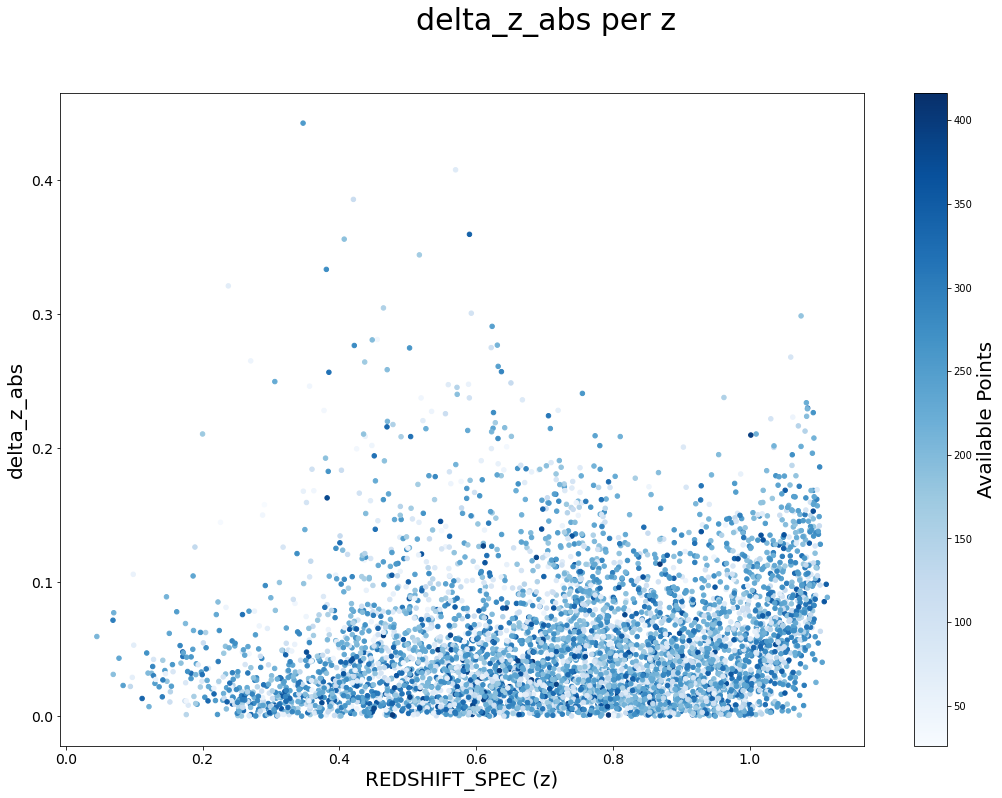

In [15]:
fig = df_dz.plot.scatter(x="REDSHIFT_SPEC", y="delta_z_abs",
                         c="Available Points", colormap='Blues',
                         figsize=(18, 12), sharex=False, fontsize=14).figure
# fig.tick_params(labelsize=6)
plt.xlabel('REDSHIFT_SPEC (z)')
plt.ylabel(u'delta_z_abs')
fig.suptitle("delta_z_abs per z", fontsize=30)
fig.savefig('delta_z_abs.pdf')


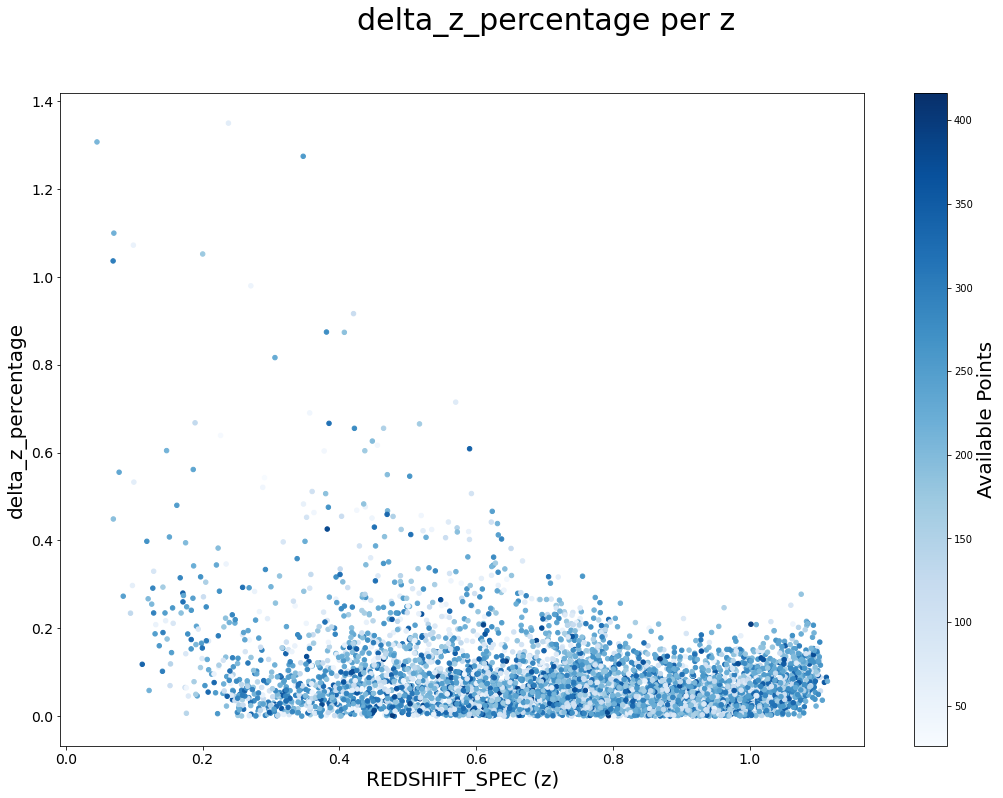

In [16]:
fig = df_dz.plot.scatter(x="REDSHIFT_SPEC", y="delta_z_percentage",
                         c="Available Points", colormap='Blues',
                         figsize=(18, 12), sharex=False, fontsize=14).figure
# fig.tick_params(labelsize=6)
plt.xlabel('REDSHIFT_SPEC (z)')
plt.ylabel(u'delta_z_percentage')
fig.suptitle("delta_z_percentage per z", fontsize=30)
fig.savefig('delta_z_percentage.pdf')


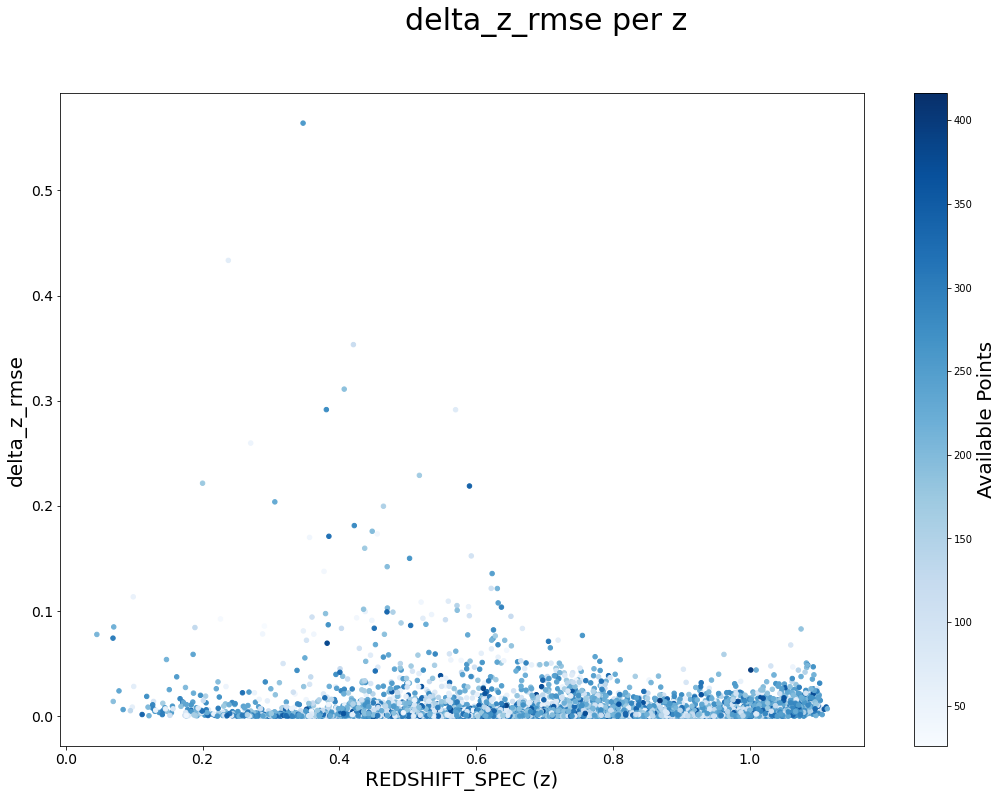

In [17]:
fig = df_dz.plot.scatter(x="REDSHIFT_SPEC", y="delta_z_rmse",
                         c="Available Points", colormap='Blues',
                         figsize=(18, 12), sharex=False, fontsize=14).figure
# fig.tick_params(labelsize=6)
plt.xlabel('REDSHIFT_SPEC (z)')
plt.ylabel(u'delta_z_rmse')
fig.suptitle("delta_z_rmse per z", fontsize=30)
fig.savefig('delta_z_rmse.pdf')


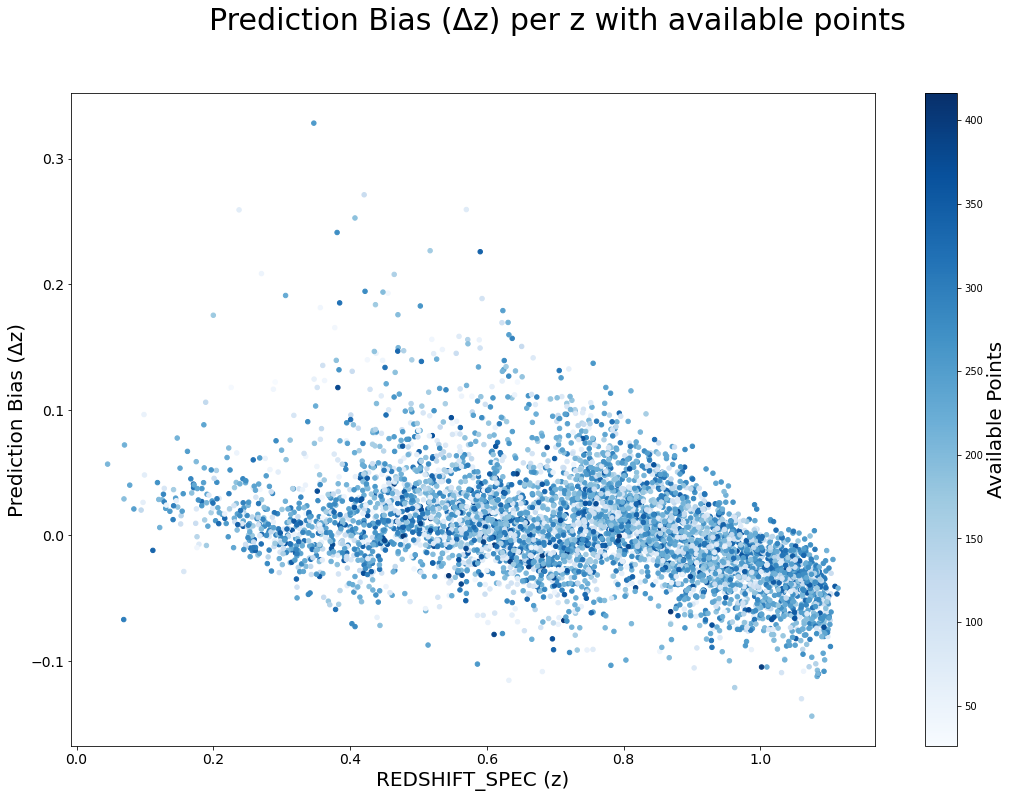

In [18]:
fig = df_dz.plot.scatter(x="REDSHIFT_SPEC", y="prediction_bias",
                         c="Available Points", colormap='Blues',
                         figsize=(18, 12), sharex=False, fontsize=14).figure
# fig.tick_params(labelsize=6)
plt.xlabel('REDSHIFT_SPEC (z)')
plt.ylabel(u'Prediction Bias (Δz)')
fig.suptitle(u"Prediction Bias (Δz) per z with available points", fontsize=30)
fig.savefig('prediction_bias.pdf')


# Barplot per bin

In [19]:
df_dz

,REDSHIFT_SPEC,zphot,delta_z,delta_z_abs,prediction_bias,delta_z_percentage,delta_z_rmse,Available Points
ID,,,,,,,,
SN10005,1.08327,0.964674,0.118596,0.118596,-0.056928,0.109480,0.012984,89
SN10007,0.82331,0.803352,0.019958,0.019958,-0.010946,0.024242,0.000484,266
SN100361,0.90012,0.857132,0.042988,0.042988,-0.022624,0.047758,0.002053,230
SN100471,0.92640,0.955625,-0.029225,0.029225,0.015171,0.031547,0.000922,299
SN100490,0.73814,0.639855,0.098285,0.098285,-0.056546,0.133152,0.013087,56
...,...,...,...,...,...,...,...,...
SN98918,0.76083,0.874126,-0.113296,0.113296,0.064342,0.148911,0.016871,170
SN99404,0.89529,0.863056,0.032234,0.032234,-0.017008,0.036004,0.001161,275
SN99438,0.75966,0.804120,-0.044460,0.044460,0.025266,0.058526,0.002602,374


In [20]:
# fig = df_dz.plot.bar(x="REDSHIFT_SPEC", y="delta_z_abs",
#                          figsize=(18, 12), sharex=False, fontsize=14).figure
# # fig.tick_params(labelsize=6)
# plt.xlabel('REDSHIFT_SPEC (z)')
# plt.ylabel(u'prediction_bias')
# fig.suptitle("prediction_bias per z", fontsize=30)
# fig.savefig('t.pdf')


In [21]:
z_min = df_dz.REDSHIFT_SPEC.min()
z_max = df_dz.REDSHIFT_SPEC.max()

In [22]:
begin = 0.0
end = 1.21
interval = 0.1
ranges = [(i/10, (i+1)/10) for i in range(int((end-begin)/interval))]

In [23]:
ranges

[(0.0, 0.1),
 (0.1, 0.2),
 (0.2, 0.3),
 (0.3, 0.4),
 (0.4, 0.5),
 (0.5, 0.6),
 (0.6, 0.7),
 (0.7, 0.8),
 (0.8, 0.9),
 (0.9, 1.0),
 (1.0, 1.1),
 (1.1, 1.2)]

In [24]:
dfs = {
   f"{str(_range[0])}_{str(_range[1])}": df_dz[(df_dz.REDSHIFT_SPEC <= _range[1]) & (df_dz.REDSHIFT_SPEC > _range[0])] for _range in ranges
}

In [33]:
dfs['0.0_0.1']

,REDSHIFT_SPEC,zphot,delta_z,delta_z_abs,prediction_bias,delta_z_percentage,delta_z_rmse,Available Points
ID,,,,,,,,
SN20557,0.04545,0.104877,-0.059427,0.059427,0.056844,1.307531,0.077703,206
SN215473,0.09940,0.152376,-0.052976,0.052976,0.048186,0.532956,0.028234,65
SN222027,0.07015,0.147306,-0.077156,0.077156,0.072099,1.099876,0.084862,215
SN278911,0.09868,0.204514,-0.105834,0.105834,0.096328,1.072496,0.113506,53
SN319694,0.06905,-0.002525,0.071575,0.071575,-0.066952,1.036570,0.074193,299
SN345661,0.07783,0.121062,-0.043232,0.043232,0.040110,0.555465,0.024014,233
SN383658,0.09729,0.126234,-0.028944,0.028944,0.026377,0.297498,0.008611,62
SN46940,0.06939,0.100542,-0.031152,0.031152,0.029131,0.448945,0.013986,191
SN603327,0.08385,0.106754,-0.022904,0.022904,0.021132,0.273149,0.006256,245


In [25]:
rmses = {
    key: ((df.REDSHIFT_SPEC - df.zphot) ** 2).mean() ** .5 for key, df in dfs.items()
}

In [34]:
prediction_biases = {
    key: (df.prediction_bias).mean() for key, df in dfs.items()
}

In [26]:
rmses

{'0.0_0.1': 0.05771273562048098,
 '0.1_0.2': 0.04340895261082067,
 '0.2_0.3': 0.054460359050993945,
 '0.3_0.4': 0.064856908099572,
 '0.4_0.5': 0.07779909784861092,
 '0.5_0.6': 0.07562250819401665,
 '0.6_0.7': 0.0694537483594757,
 '0.7_0.8': 0.07539588102571915,
 '0.8_0.9': 0.05532518504754976,
 '0.9_1.0': 0.06461567725241192,
 '1.0_1.1': 0.09587500507945095,
 '1.1_1.2': 0.11561873124323026}

In [27]:
[str(key) for key in rmses.keys()]

['0.0_0.1',
 '0.1_0.2',
 '0.2_0.3',
 '0.3_0.4',
 '0.4_0.5',
 '0.5_0.6',
 '0.6_0.7',
 '0.7_0.8',
 '0.8_0.9',
 '0.9_1.0',
 '1.0_1.1',
 '1.1_1.2']

In [37]:
df_rmses = pd.DataFrame(rmses.values(), columns=["RMSE"])
df_rmses["bins"] = [f"[{str(key).replace('_',', ')}]" for key in rmses.keys()]

df_prediction_biases = pd.DataFrame(prediction_biases.values(), columns=["Prediction Biases"])
df_prediction_biases["bins"] = [f"[{str(key).replace('_',', ')}]" for key in prediction_biases.keys()]

In [29]:
df_rmses

,RMSE,bins
0,0.057713,"[0.0, 0.1]"
1,0.043409,"[0.1, 0.2]"
2,0.054460,"[0.2, 0.3]"
3,0.064857,"[0.3, 0.4]"
4,0.077799,"[0.4, 0.5]"
5,0.075623,"[0.5, 0.6]"
6,0.069454,"[0.6, 0.7]"
7,0.075396,"[0.7, 0.8]"
8,0.055325,"[0.8, 0.9]"
9,0.064616,"[0.9, 1.0]"


In [38]:
df_prediction_biases


,Prediction Biases,bins
0,0.034350,"[0.0, 0.1]"
1,0.028907,"[0.1, 0.2]"
2,0.020862,"[0.2, 0.3]"
3,0.014313,"[0.3, 0.4]"
4,0.026336,"[0.4, 0.5]"
5,0.023266,"[0.5, 0.6]"
6,0.011000,"[0.6, 0.7]"
7,0.018541,"[0.7, 0.8]"
8,0.006581,"[0.8, 0.9]"
9,-0.019163,"[0.9, 1.0]"


In [ ]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# plt.rc("legend", facecolor="b")
# plt.rc("hatch", color="b")

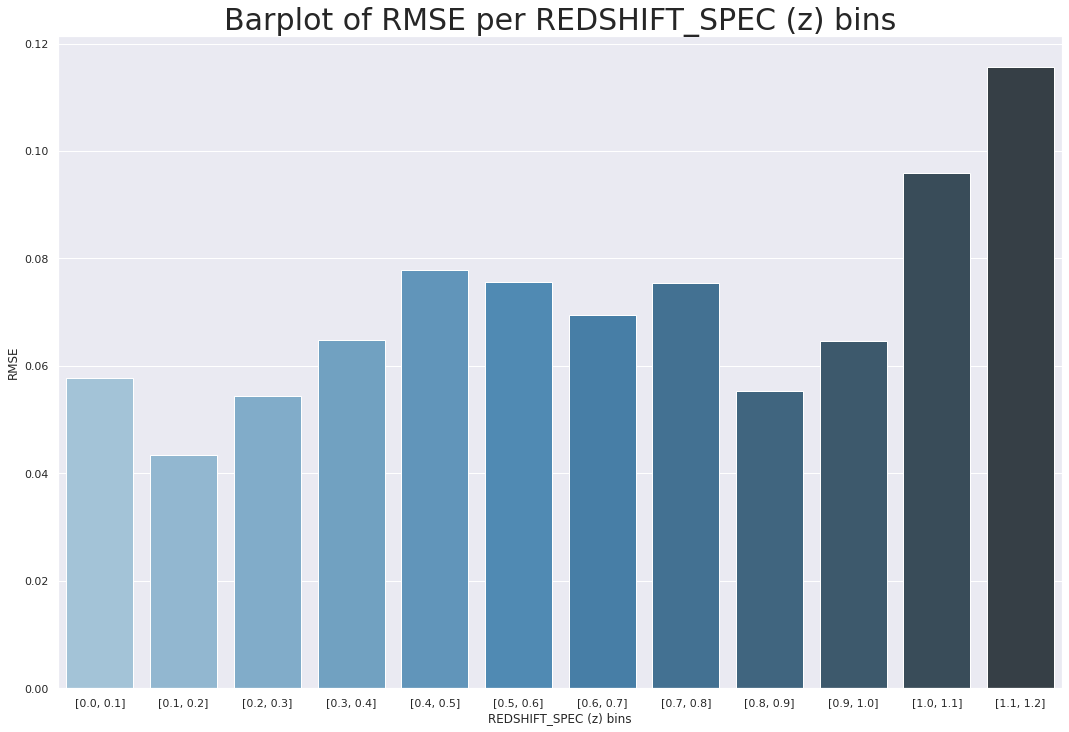

In [43]:
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(18,12)})


ax = sns.barplot(x="bins", y="RMSE", data=df_rmses,  palette="Blues_d")
ax.axes.set_title("Barplot of RMSE per REDSHIFT_SPEC (z) bins", fontsize=30)
ax.set_xlabel("REDSHIFT_SPEC (z) bins")
ax.set_ylabel("RMSE")

ax.figure.savefig("barplot_rmse.pdf") 

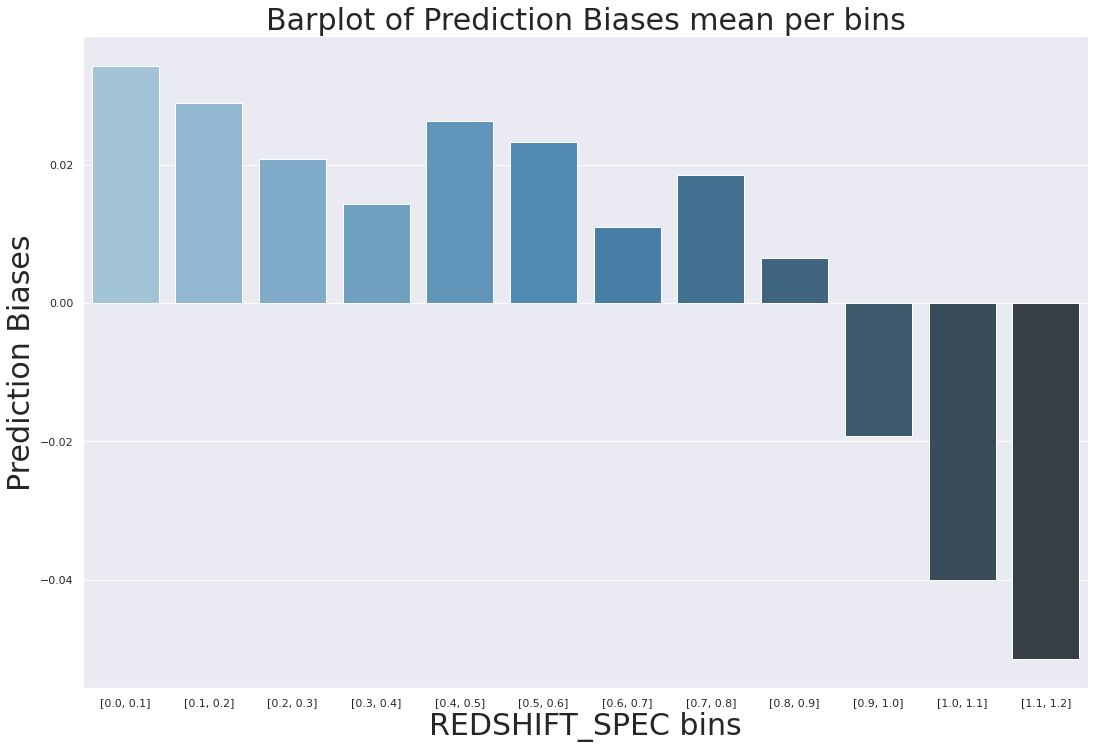

In [40]:
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(18,12)})


ax = sns.barplot(x="bins", y="Prediction Biases", data=df_prediction_biases,  palette="Blues_d")
ax.axes.set_title(u"Barplot of Prediction Bias (Δz) Mean per REDSHIFT_SPEC (z) bins", fontsize=30)
ax.set_xlabel("REDSHIFT_SPEC (z) bins")
ax.set_ylabel("Prediction Bias (Δz) Mean")

ax.figure.savefig("barplot_prediction_biases.pdf") 